<a href="https://colab.research.google.com/github/tobieabel/robokeeper/blob/master/TF2_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation with tf.data in TensorFlow 2 and ADE20K dataset

## 1. Introduction

In this notebook we are going to cover the usage of tensorflow 2 and tf.data on our own data set for semantic segmentation


The type of data we are going to manipulate consist in:
* an jpg image with 3 channels (RGB)
* a png mask with 1 channel (for each pixel we have 1 true class over 2 possible (value 100 for the ball, 0 for everything else)  

You can also find all the information by reading the official tensorflow tutorials:

* https://www.tensorflow.org/tutorials/load_data/images
* https://www.tensorflow.org/tutorials/images/segmentation

This notebook assumes that your environment is Google Colab.

## 2. Preparing the Environment

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 8.3MB/s 


In [ ]:
from glob import glob
import shutil
import argparse
import zipfile
import hashlib
import requests
from tqdm import tqdm
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import tensorflow_addons as tfa

# For more information about autotune:
# https://www.tensorflow.org/guide/data_performance#prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.4.1


### 2.1. Downloading the dataset

We can implement a small tool to download ADE2k in colab environment directly.

In [ ]:

# Uncomment those 2 lines to use your own Google drive for data
from google.colab import drive
drive.mount('data')

Mounted at data


Don't think we need this code, as we are not using the ADE2K dataset

In [ ]:
# some helper functions to download the dataset
# this code comes mainly from gluoncv.utils
def check_sha1(filename, sha1_hash):
    """Check whether the sha1 hash of the file content matches the expected hash.
    Parameters
    ----------
    filename : str
        Path to the file.
    sha1_hash : str
        Expected sha1 hash in hexadecimal digits.
    Returns
    -------
    bool
        Whether the file content matches the expected hash.
    """
    sha1 = hashlib.sha1()
    with open(filename, 'rb') as f:
        while True:
            data = f.read(1048576)
            if not data:
                break
            sha1.update(data)

    sha1_file = sha1.hexdigest()
    l = min(len(sha1_file), len(sha1_hash))
    return sha1.hexdigest()[0:l] == sha1_hash[0:l]

def download(url, path=None, overwrite=False, sha1_hash=None):
    """Download an given URL
    Parameters
    ----------
    url : str
        URL to download
    path : str, optional
        Destination path to store downloaded file. By default stores to the
        current directory with same name as in url.
    overwrite : bool, optional
        Whether to overwrite destination file if already exists.
    sha1_hash : str, optional
        Expected sha1 hash in hexadecimal digits. Will ignore existing file when hash is specified
        but doesn't match.
    Returns
    -------
    str
        The file path of the downloaded file.
    """
    if path is None:
        fname = url.split('/')[-1]
    else:
        path = os.path.expanduser(path)
        if os.path.isdir(path):
            fname = os.path.join(path, url.split('/')[-1])
        else:
            fname = path

    if overwrite or not os.path.exists(fname) or (sha1_hash and not check_sha1(fname, sha1_hash)):
        dirname = os.path.dirname(os.path.abspath(os.path.expanduser(fname)))
        if not os.path.exists(dirname):
            os.makedirs(dirname)

        print('Downloading %s from %s...'%(fname, url))
        r = requests.get(url, stream=True)
        if r.status_code != 200:
            raise RuntimeError("Failed downloading url %s"%url)
        total_length = r.headers.get('content-length')
        with open(fname, 'wb') as f:
            if total_length is None: # no content length header
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk: # filter out keep-alive new chunks
                        f.write(chunk)
            else:
                total_length = int(total_length)
                for chunk in tqdm(r.iter_content(chunk_size=1024),
                                  total=int(total_length / 1024. + 0.5),
                                  unit='KB', unit_scale=False, dynamic_ncols=True):
                    f.write(chunk)

        if sha1_hash and not check_sha1(fname, sha1_hash):
            raise UserWarning('File {} is downloaded but the content hash does not match. ' \
                              'The repo may be outdated or download may be incomplete. ' \
                              'If the "repo_url" is overridden, consider switching to ' \
                              'the default repo.'.format(fname))

    return fname

def download_ade(path, overwrite=False):

    """Download ADE20K
    Parameters
    ----------
    path : str
      Location of the downloaded files.
    overwrite : bool, optional
      Whether to overwrite destination file if already exists.
    """
    if not os.path.exists(path):
        os.mkdir(path)
    _AUG_DOWNLOAD_URLS = [
      ('http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip', '219e1696abb36c8ba3a3afe7fb2f4b4606a897c7'),
      ('http://data.csail.mit.edu/places/ADEchallenge/release_test.zip', 'e05747892219d10e9243933371a497e905a4860c'),]
    download_dir = os.path.join(path, 'downloads')
    if not os.path.exists(download_dir):
        os.mkdir(download_dir)
    for url, checksum in _AUG_DOWNLOAD_URLS:
        filename = download(url, path=download_dir, overwrite=overwrite, sha1_hash=checksum)
        # extract
        with zipfile.ZipFile(filename,"r") as zip_ref:
            zip_ref.extractall(path=path)

Set up folders under /content for images and validations.  Under each there should be and training and validations folders

In [ ]:
!mkdir images annotations
!mkdir annotations/training annotations/validations
!mkdir images/training images/validations

In [ ]:
root = "/content/"
dataset_path = root + "images/"
training_data = "training/"
val_data = "validations/"

In [ ]:
download_ade(root, overwrite=False)

  0%|          | 0/944709 [00:00<?, ?KB/s]

944710KB [06:01, 2614.56KB/s]                            
  0%|          | 0/206856 [00:00<?, ?KB/s]

100%|██████████| 206856/206856 [01:21<00:00, 2525.88KB/s]


Load your jpg/png files manually - should just split files into different folders andupload the folders!

## 3. Creating our Dataloader

Amend below to reflect your images

In [ ]:
# Image size that we are going to use
IMG_WIDTH = 480
IMG_HEIGHT = 640
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 1 class (ball, pixel strenght = 100) + `not labeled`
N_CLASSES = 150 #for some reason when I reduced this to 1 it broke.  See where N_Classes is referenced

### 3.1. Creating a source dataset

In [ ]:
TRAINSET_SIZE = len(glob(dataset_path + training_data + "*.jpg"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(dataset_path + val_data + "*.jpg"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 3 images.
The Validation Dataset contains 2 images.


For each images of our dataset, we will apply some operations wrapped into a function. Then we will map the whole dataset with this function.   

Below we read and convert the jpg files to tensors, as well as the mask png files.  


In [ ]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # For one Image path:
    # .../trainset/images/training/ADE_train_00000001.jpg
    # Its corresponding annotation path is:
    # .../trainset/annotations/training/ADE_train_00000001.png
    mask_path = tf.strings.regex_replace(img_path, "images", "annotations")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess up with our N_CLASS = 150
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    # Note that we have to convert the new value (0)
    # With the same dtype than the tensor itself

    return {'image': image, 'segmentation_mask': mask}

In case you would like to load any other image format, you should modify the `parse_image` function. TensorFlow I/O provide additional tools that might help you. 
For example, in the case of loading TIFF images, you can use:

```python
import tensorflow as tf
import tensorflow.io as tfio
...
def parse_image(img_path: str) -> dict:
...
image = tf.io.read_file(img_path)
tfio.experimental.image.decode_tiff(image)
...
```

In this case, don't forget to modify the number of channels when implementing the model later.

USe Dataset.list_files to create a list of the images for training and validation, and then pass the list to the parse image function as part of the map function

In [ ]:
train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.jpg")
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(dataset_path + val_data + "*.jpg")
val_dataset =val_dataset.map(parse_image)

### 3.2. Applying some transformations to our dataset

In [ ]:
# Here we are using the decorator @tf.function
# if you want to know more about it:
# https://www.tensorflow.org/api_docs/python/tf/function

@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [SIZE,SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [SIZE,SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its annotation.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its annotation.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the annotation also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_HEIGHT, IMG_WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_HEIGHT, IMG_WIDTH))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    """Normalize and resize a test image and its annotation.

    Notes
    -----
    Since this is for the test set, we don't need to apply
    any data augmentation technique.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_HEIGHT, IMG_WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_HEIGHT, IMG_WIDTH))

    input_image, input_mask = normalize(input_image, input_mask)
   
    return input_image, input_mask

Manipulating datasets in tensorflow can be complicated. You can read the official documentation to understand how they are working: https://www.tensorflow.org/guide/data#training_workflows

In [ ]:
BATCH_SIZE = 1

# for reference about the BUFFER_SIZE in shuffle:
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

# how shuffle works: https://stackoverflow.com/a/53517848

<PrefetchDataset shapes: ((None, 640, 480, 3), (None, 640, 480, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 640, 480, 3), (None, 640, 480, 1)), types: (tf.float32, tf.float32)>


## 4. Visualizing the Dataset

It seems everything is fine. It can be very hard to build your model by having bugs in your dataset. This makes the development process very painful since the potential bugs from your model are adding up to the potential bugs in your dataloaders. Therefore, it is recommended to make sure that you have what you expect.  
For that, we are going to develop simple functions to vizualize the content of our dataloaders.

In [ ]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

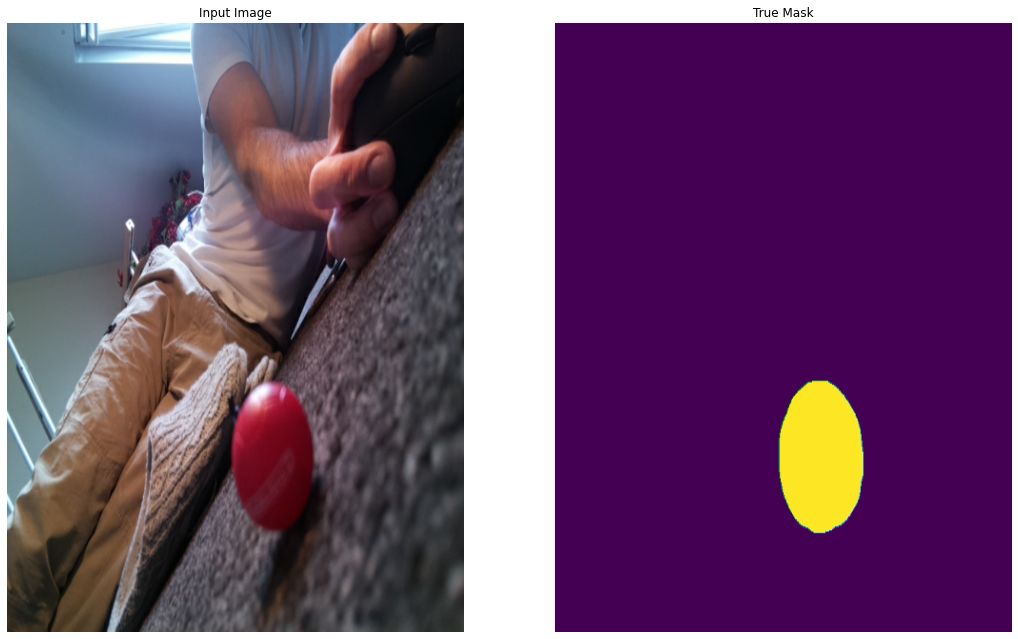

In [ ]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

The dimensions are the ones we expect and it shows up properly. We can start the development of the model itself.

## 5. Developing the Model (UNet) Using Keras Functional API
For this example, we are going to implement a popular architecture: UNet. In a sense, it is not the best for a titorial since this model is very heavy. But I found the exercise interesting. Especially because we are going to use the functional API provided by keras.

This architecture was introduce in the paper **U-Net: Convolutional Networks for Biomedical Image Segmentation** that you can read there: https://arxiv.org/abs/1505.04597  

You can also read my notes on this paper there: https://yann-leguilly.gitlab.io/post/2019-12-11-unet-biomedical-images/   
Basically we are going to reproduce this:  

![figure 1](https://yann-leguilly.gitlab.io/img/unet_1/figure_1.png)

### 5.1. Implementation

In [ ]:
# -- Keras Functional API -- #
# -- UNet Implementation -- #
# Everything here is from tensorflow.keras.layers
# I imported tensorflow.keras.layers * to make it easier to read
dropout_rate = 0.5
input_size = (IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)

# If you want to know more about why we are using `he_normal`: 
# https://stats.stackexchange.com/questions/319323/whats-the-difference-between-variance-scaling-initializer-and-xavier-initialize/319849#319849  
# Or the excelent fastai course: 
# https://github.com/fastai/course-v3/blob/master/nbs/dl2/02b_initializing.ipynb
initializer = 'he_normal'


# -- Encoder -- #
# Block encoder 1
inputs = Input(shape=input_size)
conv_enc_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(inputs)
conv_enc_1 = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer=initializer)(conv_enc_1)

# Block encoder 2
max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_2)

# Block  encoder 3
max_pool_enc_3 = MaxPooling2D(pool_size=(2, 2))(conv_enc_2)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_3)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_3)

# Block  encoder 4
max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(conv_enc_3)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_4)
# -- Encoder -- #

# ----------- #
maxpool = MaxPooling2D(pool_size=(2, 2))(conv_enc_4)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(maxpool)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv)
# ----------- #

# -- Dencoder -- #
# Block decoder 1
up_dec_1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv))
merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_1)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_1)

# Block decoder 2
up_dec_2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_1))
merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_2)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_2)

# Block decoder 3
up_dec_3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_2))
merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_3)

# Block decoder 4
up_dec_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_3))
merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_4)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
conv_dec_4 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
# -- Dencoder -- #

output = Conv2D(N_CLASSES, 1, activation = 'softmax')(conv_dec_4)

Now we can load and compile the model to make sure that there is no bugs.

In [ ]:
model = tf.keras.Model(inputs = inputs, outputs = output)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### 5.2. Sanity Check

We can visualize a sample prediction to be sure that we see what we expect.

In [ ]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predicitons
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask
    
def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])

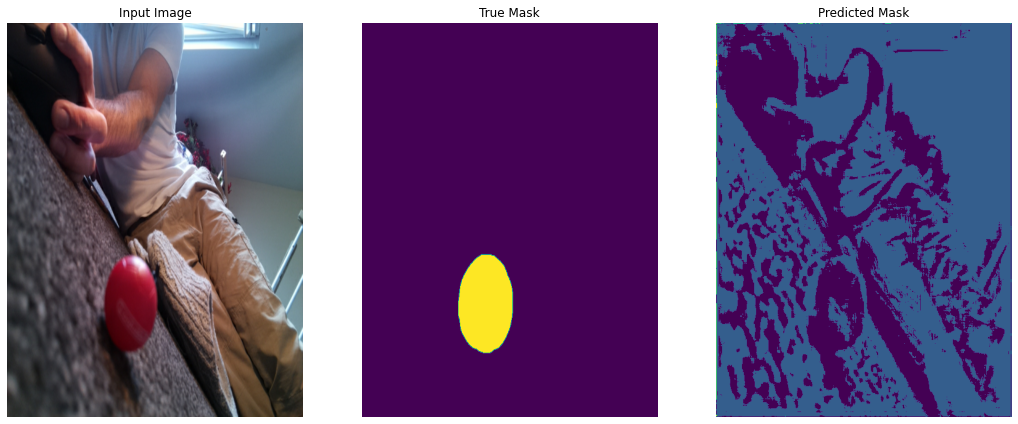

In [ ]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

show_predictions()

The far right image is a prediction with random weights. We are ready to start the training!

## 6. Training our Model

### 6.1. Simpler training loop

Let's run a simple training loop with only 1 epoch first. 

In [ ]:
EPOCHS = 1

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

In [ ]:
# sometimes it can be very interesting to run some batches on cpu
# because the tracing is way better than on GPU
# you will have more obvious error message
# but in our case, it takes A LOT of time

# On CPU
# with tf.device("/cpu:0"):
#     model_history = model.fit(dataset['train'], epochs=EPOCHS,
#                               steps_per_epoch=STEPS_PER_EPOCH,
#                               validation_steps=VALIDATION_STEPS,
#                               validation_data=dataset['val'])

# On GPU
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'])

3/3 [==============================] - 4s 590ms/step - loss: 5.0173 - accuracy: 0.5454 - val_loss: 5.0060 - val_accuracy: 0.9440


Everything looks great! We can start our 'real' training.

### 6.2. More Advanced Training Loop

Keras implements what we call 'callbacks'. We can use them to run custom functions at any step of the training. Here we are going to show the output of the model compared to the original image and the ground truth after each epochs.
We are also going to collect some useful metrics to make sure our training is happening well by using tensorboard.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 20

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [
    # to show samples after each epoch
    DisplayCallback(),
    # to collect some useful metrics and visualize them in tensorboard
    tensorboard_callback,
    # if no accuracy improvements we can stop the training directly
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    # to save checkpoints
    tf.keras.callbacks.ModelCheckpoint('best_model_unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

model = tf.keras.Model(inputs = inputs, outputs = output)

# # here I'm using a new optimizer: https://arxiv.org/abs/1908.03265
optimizer=tfa.optimizers.RectifiedAdam(lr=1e-3)

loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
model.compile(optimizer=optimizer, loss = loss,
                  metrics=['accuracy'])

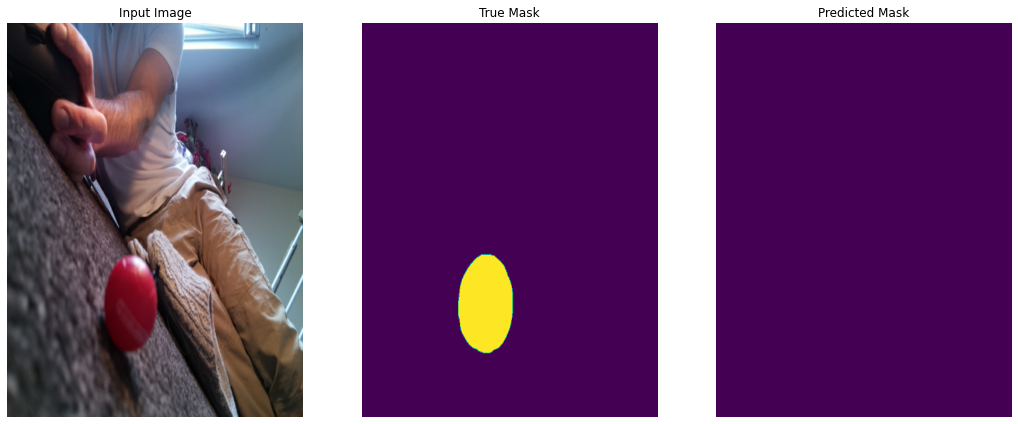


Sample Prediction after epoch 20


Epoch 00020: val_loss did not improve from 3.74586


In [ ]:
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=dataset['val'],
                    callbacks=callbacks)